<a href="https://colab.research.google.com/github/SyedDaniyalHassan/dlp_project/blob/main/Dae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denosing autoencoder


### Git Clone


In [1]:
! git clone https://github.com/SyedDaniyalHassan/dlp_project.git

Cloning into 'dlp_project'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 132 (delta 62), reused 95 (delta 28), pack-reused 0
Receiving objects: 100% (132/132), 21.15 MiB | 16.90 MiB/s, done.
Resolving deltas: 100% (62/62), done.


### Imports

In [2]:
import os
os.chdir("./dlp_project")

In [3]:
import helper
from tensorflow import keras
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint


%matplotlib inline
np.random.seed(100)

In [4]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

In [5]:
(x_train , _) , (x_test,_) =cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [6]:
num_training_exmples = x_train.shape[0]
lenght = x_train.shape[1]
width = x_train[2]
channels = x_train.shape[3]

Actual image AxesImage(54,36;334.8x217.44)


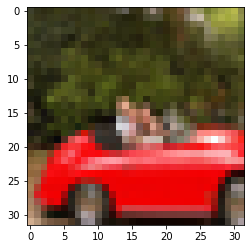

In [7]:
image_id = 99
pixel = np.array([15,15,255,255,0])
img = perturb_image(pixel , x_train[image_id])
print("Actual image",plt.imshow(x_train[image_id]))


Perturb image AxesImage(54,36;334.8x217.44)


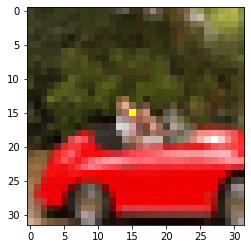

In [8]:
print("Perturb image", plt.imshow(img[0]) ) 

### Create a perturb dataset

In [9]:
distrub_imgs = []
for i in range(num_training_exmples):
  p1 = np.random.randint(0,31)
  p2 = np.random.randint(0,31)
  red_bool = np.random.randint(0,2)
  green_bool = np.random.randint(0,2)
  blue_bool = np.random.randint(0,2)
  r, g, b =0,0,0
  if(red_bool):
    r =255
  if(green_bool):
    g = 255
  if(blue_bool):
    b=255
  if(red_bool ==0 and green_bool ==0 and blue_bool==0):
    r=255
    b=255
  pixel = np.array([p1,p2,r,g,b])
  distrub_imgs.append(perturb_image(pixel,x_train[i])[0])

In [10]:
test_distrub = []
for i in range(len(x_test)):
  p1 = np.random.randint(0,31)
  p2 = np.random.randint(0,31)
  red_bool = np.random.randint(0,2)
  green_bool = np.random.randint(0,2)
  blue_bool = np.random.randint(0,2)
  r, g, b =0,0,0
  if(red_bool):
    r =255
  if(green_bool):
    g = 255
  if(blue_bool):
    b=255
  if(red_bool ==0 and green_bool ==0 and blue_bool==0):
    r=255
    b=255
  pixel = np.array([p1,p2,r,g,b])
  test_distrub.append(perturb_image(pixel,x_test[i])[0])

In [11]:
distrub_imgs = np.array(distrub_imgs)
test_distrub = np.array(test_distrub)

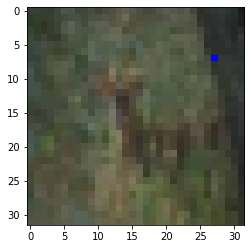

In [12]:
plt.imshow(distrub_imgs[10])

# Data preporocessing

In [13]:
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
distrub_imgs = distrub_imgs.astype("float32")/255
test_distrub = test_distrub.astype("float32")/255

# create a denoing auto encoder

### Convolution Block

In [ ]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x


### Deconvolution Block

In [ ]:
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

### Denoising autoencoder 
inspired by U-net architecture

In [ ]:
def denoising_autoencoder():
   dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
   conv_block1 = conv_block(dae_inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 256, 3)
   conv_block5 = conv_block(conv_block4, 256, 3, 1)

   deconv_block1 = deconv_block(conv_block5, 256, 3)
   merge1 = Concatenate()([deconv_block1, conv_block3])
   deconv_block2 = deconv_block(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = deconv_block(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = deconv_block(merge3, 32, 3)
   final_deconv = Conv2DTranspose(filters=3,kernel_size=3,padding='same')(deconv_block4)
   dae_outputs = Activation('sigmoid', name='Dae_output')(final_deconv)
  
   return Model(dae_inputs, dae_outputs, name='Dae')

# Train Model

In [ ]:
dae = denoising_autoencoder()
dae.compile(loss='mse', optimizer='adam')

checkpoint = ModelCheckpoint('./networks/models/Dae_best.h5', verbose=1, save_best_only=True, save_weights_only=True)

dae.fit(distrub_imgs,
       x_train,
       validation_data=(test_distrub, x_test),
       epochs=40,
       batch_size=128,
       callbacks=[checkpoint])

Epoch 1/40
391/391 [==============================] - 54s 60ms/step - loss: 0.0036 - val_loss: 0.0062

Epoch 00001: val_loss improved from inf to 0.00615, saving model to ./networks/models/Dae_best.h5
Epoch 2/40
391/391 [==============================] - 23s 58ms/step - loss: 8.8888e-04 - val_loss: 6.9241e-04

Epoch 00002: val_loss improved from 0.00615 to 0.00069, saving model to ./networks/models/Dae_best.h5
Epoch 3/40
391/391 [==============================] - 23s 58ms/step - loss: 7.8790e-04 - val_loss: 6.8728e-04

Epoch 00003: val_loss improved from 0.00069 to 0.00069, saving model to ./networks/models/Dae_best.h5
Epoch 4/40
391/391 [==============================] - 23s 58ms/step - loss: 6.6767e-04 - val_loss: 5.4405e-04

Epoch 00004: val_loss improved from 0.00069 to 0.00054, saving model to ./networks/models/Dae_best.h5
Epoch 5/40
391/391 [==============================] - 23s 58ms/step - loss: 6.1747e-04 - val_loss: 8.6329e-04

Epoch 00005: val_loss did not improve from 0.0005

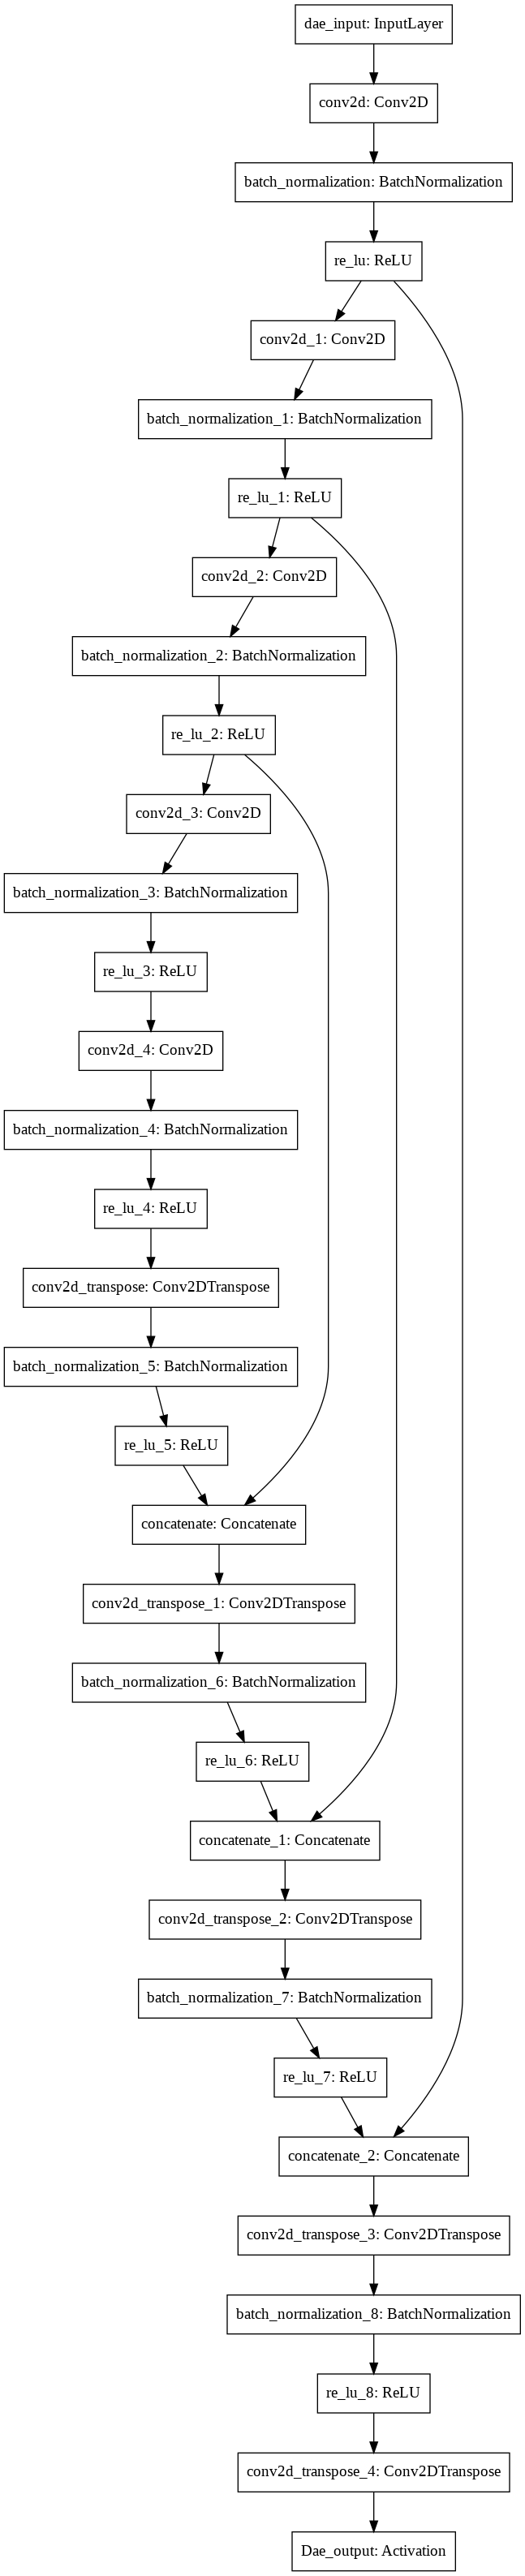

In [ ]:
keras.utils.plot_model(dae,to_file="./images/dae.png")

In [ ]:
remove_pixel_attack = dae.predict(test_distrub)

In [ ]:
(remove_pixel_attack.shape)

(10000, 32, 32, 3)

Distrub image AxesImage(54,36;334.8x217.44)


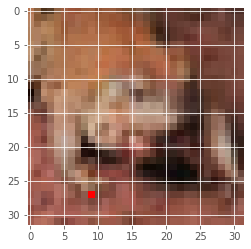

In [ ]:
print("Distrub image",plt.imshow(test_distrub[5]))


Removing attack image  AxesImage(54,36;334.8x217.44)


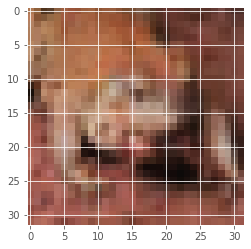

In [ ]:
print("Removing attack image ",plt.imshow(remove_pixel_attack[5]))

In [29]:
import keras
import tensorflow as tf
import numpy as np
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, Dense, Input, add, Activation, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint 
from keras.models import Model, load_model
from keras import optimizers, regularizers
from networks.train_plot import PlotLearning


In [32]:
(x_train , y_train) ,(x_test,y_test)  = cifar10.load_data()

In [34]:
x_train = x_train.astype("float32") /255
x_test = x_test.astype("float32") /255
y_train = tf.keras.utils.to_categorical(y_train ,num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test,num_classes=10)

In [21]:

def residual_network(img_input,classes_num=10,stack_n=5):
    def residual_block(intput,out_channel,increase=False):
        if increase:
            stride = (2,2)
        else:
            stride = (1,1)

        pre_bn   = BatchNormalization()(intput)
        pre_relu = Activation('relu')(pre_bn)

        conv_1 = Conv2D(out_channel,kernel_size=(3,3),strides=stride,padding='same',
                        kernel_initializer="he_normal",
                        kernel_regularizer=regularizers.l2(0.0001))(pre_relu)
        bn_1   = BatchNormalization()(conv_1)
        relu1  = Activation('relu')(bn_1)
        conv_2 = Conv2D(out_channel,kernel_size=(3,3),strides=(1,1),padding='same',
                        kernel_initializer="he_normal",
                        kernel_regularizer=regularizers.l2(0.0001))(relu1)
        if increase:
            projection = Conv2D(out_channel,
                                kernel_size=(1,1),
                                strides=(2,2),
                                padding='same',
                                kernel_initializer="he_normal",
                                kernel_regularizer=regularizers.l2(0.0001))(intput)
            block = add([conv_2, projection])
        else:
            block = add([intput,conv_2])
        return block

    # build model
    # total layers = stack_n * 3 * 2 + 2
    # stack_n = 5 by default, total layers = 32
    # input: 32x32x3 output: 32x32x16
    x = Conv2D(filters=16,kernel_size=(3,3),strides=(1,1),padding='same',
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(0.0001))(img_input)

    # input: 32x32x16 output: 32x32x16
    for _ in range(stack_n):
        x = residual_block(x,16,False)

    # input: 32x32x16 output: 16x16x32
    x = residual_block(x,32,True)
    for _ in range(1,stack_n):
        x = residual_block(x,32,False)
    
    # input: 16x16x32 output: 8x8x64
    x = residual_block(x,64,True)
    for _ in range(1,stack_n):
        x = residual_block(x,64,False)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)

    # input: 64 output: 10
    x = Dense(classes_num,activation='softmax',
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(0.0001))(x)
    return x


In [27]:
def scheduler(self, epoch):
  if epoch < 80:
    return 0.1
  if epoch < 150:
    return 0.01
  return 0.001


In [23]:
img_input = Input(shape=(32,32,3)  )
output = residual_network(img_input , 10 , 5)
resnet = Model(img_input ,output )
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 32, 32, 16)   448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 32, 32, 16)   64          conv2d_34[0][0]                  
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 32, 32, 16)   0           batch_normalization_32[0][0]     
______________________________________________________________________________________________

In [26]:
sgd = optimizers.SGD(learning_rate=0.1,momentum=0.9,nesterov=True)
resnet.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [35]:
log_file_path = r'networks/models/resnet'
tensor_board = TensorBoard(log_dir=log_file_path , histogram_freq=0)
dynamic_lr = LearningRateScheduler(scheduler)
check_points = ModelCheckpoint('networks/models/dae_res',monitor='val_loss',save_best_only=True )
plot_callbck = PlotLearning()
call_list = [dynamic_lr , tensor_board , check_points ,plot_callbck]

<Figure size 432x288 with 0 Axes>

In [36]:
datagen = ImageDataGenerator(horizontal_flip=True,
                                    width_shift_range=0.15,
                                    height_shift_range=0.15,
                                    fill_mode='constant',cval=0.)

In [37]:
datagen.fit(x_train)

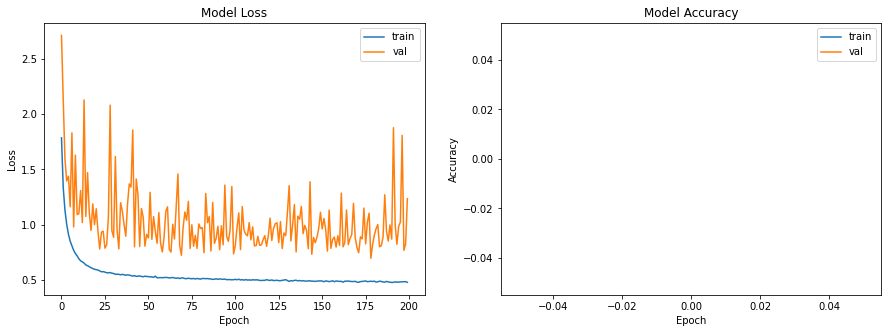

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: networks/models/dae_res/assets


In [38]:
resnet.fit_generator(datagen.flow(x_train,y_train,batch_size=128) , steps_per_epoch=50000//128 ,epochs=200 , callbacks=call_list , validation_data=(x_test,y_test) )
resnet.save('networks/models/dae_res')

In [42]:
mo = keras.models.load_model('networks/models/dae_res')

In [43]:
mo.evaluate(x_test,y_test)

313/313 [==============================] - 5s 7ms/step - loss: 1.2348 - accuracy: 0.7502


[1.23475980758667, 0.7501999735832214]